In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
from retrieveData import DataHandler
import scipy.stats as stats

file_path = '/Users/davidboktor/Documents/Tiingo_API.txt'
handler = DataHandler(file_path)


test = handler.test_connections()

Connection successful: {'message': 'You successfully sent a request'}


In [110]:
handler = DataHandler(file_path)
data = handler.get_historical_data('AAPL', start_date='2015-01-01')
data.reset_index(inplace=True)
data.head()

INFO:retrieveData:Successfully fetched data for AAPL


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2015-01-02,109.33,111.44,107.350,111.39,53204626,24.372730,24.843109,23.931333,24.831962,212818504,0.0,1.0
1,2015-01-05,106.25,108.65,105.410,108.29,64285491,23.686112,24.221139,23.498852,24.140885,257141964,0.0,1.0
2,2015-01-06,106.26,107.43,104.630,106.54,65797116,23.688341,23.949167,23.324968,23.750761,263188464,0.0,1.0
3,2015-01-07,107.75,108.20,106.695,107.20,40105934,24.020504,24.120822,23.785315,23.897893,160423736,0.0,1.0
4,2015-01-08,111.89,112.15,108.700,109.23,59364547,24.943426,25.001388,24.232286,24.350438,237458188,0.0,1.0


In [111]:
fig = px.line(data, x='date', y='adjClose', title='Apple Stock Price')
fig.show()


In [112]:
data['returns'] = data['adjClose'].pct_change()
fig = px.line(data, x='date', y='returns', title='Apple Stock Returns')
fig.show()

In [113]:
data['log_returns'] = np.log(data['adjClose'] / data['adjClose'].shift(1))
fig = px.line(data, x='date', y='log_returns', title='Apple Stock Log Returns')
fig.show()

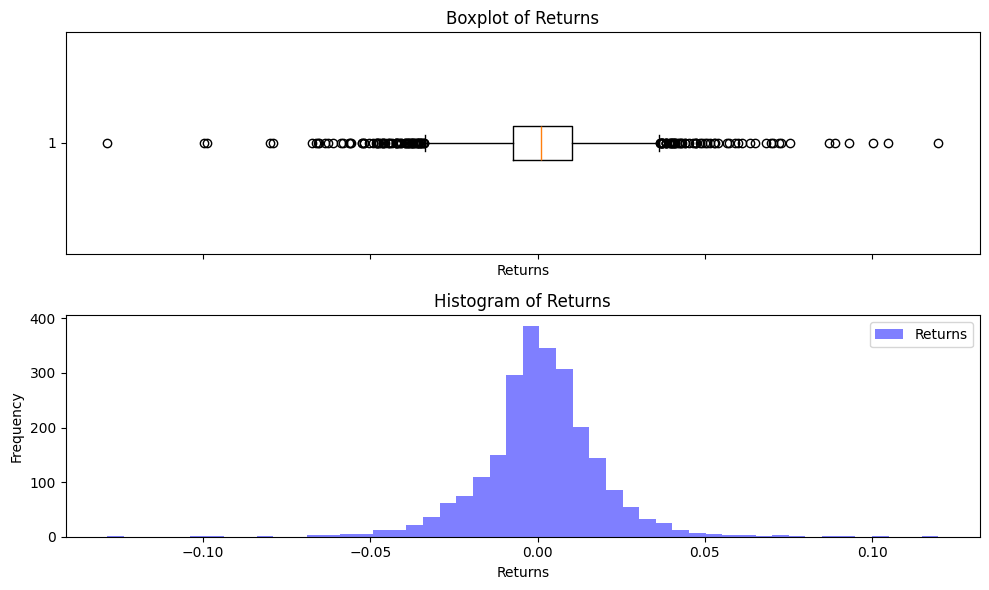

In [114]:
fig, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

# Boxplot
axes[0].boxplot(data['returns'].dropna(), vert=False)
axes[0].set_title('Boxplot of Returns')
axes[0].set_xlabel('Returns')

# Histogram
axes[1].hist(data['returns'].dropna(), bins=50, alpha=0.5, color='blue', label='Returns')
axes[1].set_title('Histogram of Returns')
axes[1].set_xlabel('Returns')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

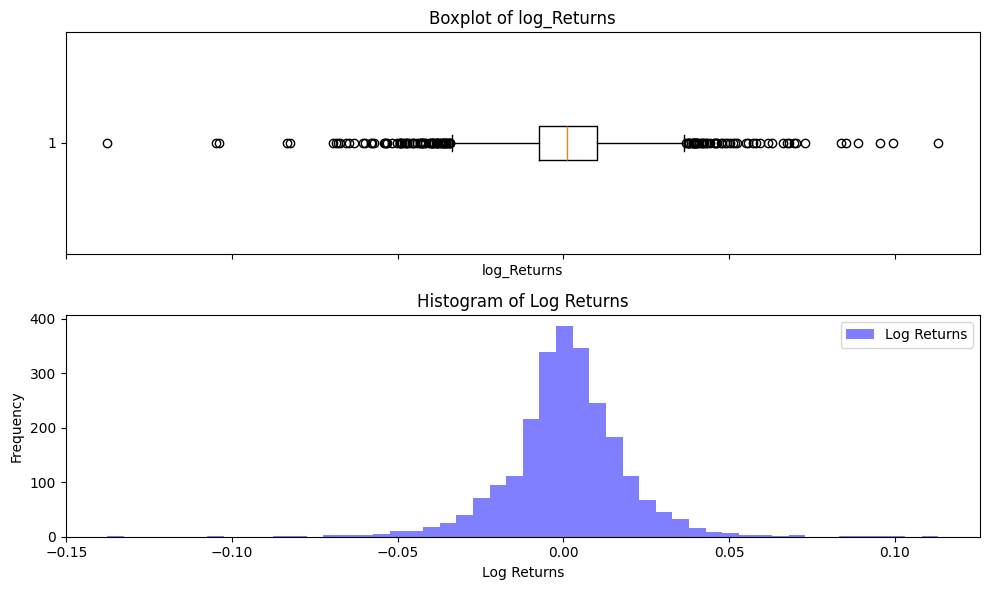

In [115]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Boxplot
axes[0].boxplot(data['log_returns'].dropna(), vert=False)
axes[0].set_title('Boxplot of log_Returns')
axes[0].set_xlabel('log_Returns')

# Histogram
axes[1].hist(data['log_returns'].dropna(), bins=50, alpha=0.5, color='blue', label='Log Returns')
axes[1].set_title('Histogram of Log Returns')
axes[1].set_xlabel('Log Returns')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

Probability Density Function

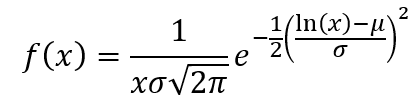

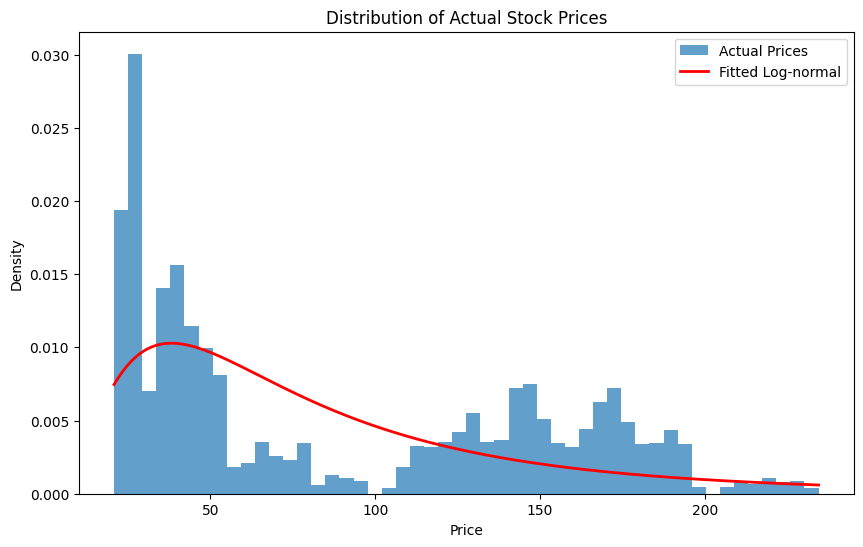

In [117]:
prices = data['adjClose'].dropna()
mu = np.log(prices).mean()
sigma = np.log(prices).std()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(prices, bins=50, density=True, alpha=0.7, label='Actual Prices')
x_stock = np.linspace(min(prices), max(prices), len(prices))
data['pdf_stock'] = stats.lognorm.pdf(x_stock, s=sigma, scale=np.exp(mu))
ax.plot(x_stock, data['pdf_stock'], 'r-', lw=2, label='Fitted Log-normal')
ax.set_title("Distribution of Actual Stock Prices")
ax.set_xlabel("Price")
ax.set_ylabel("Density")
ax.legend()
plt.show()

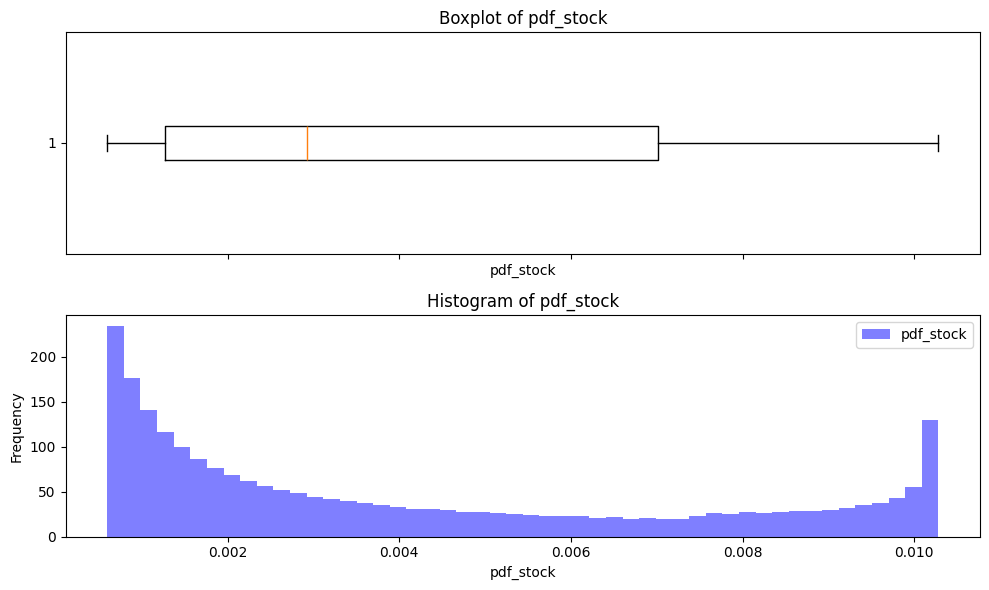

In [118]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Boxplot
axes[0].boxplot(data['pdf_stock'].dropna(), vert=False)
axes[0].set_title('Boxplot of pdf_stock')
axes[0].set_xlabel('pdf_stock')

# Histogram
axes[1].hist(data['pdf_stock'].dropna(), bins=50, alpha=0.5, color='blue', label='pdf_stock')
axes[1].set_title('Histogram of pdf_stock')
axes[1].set_xlabel('pdf_stock')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

Q-Q plot

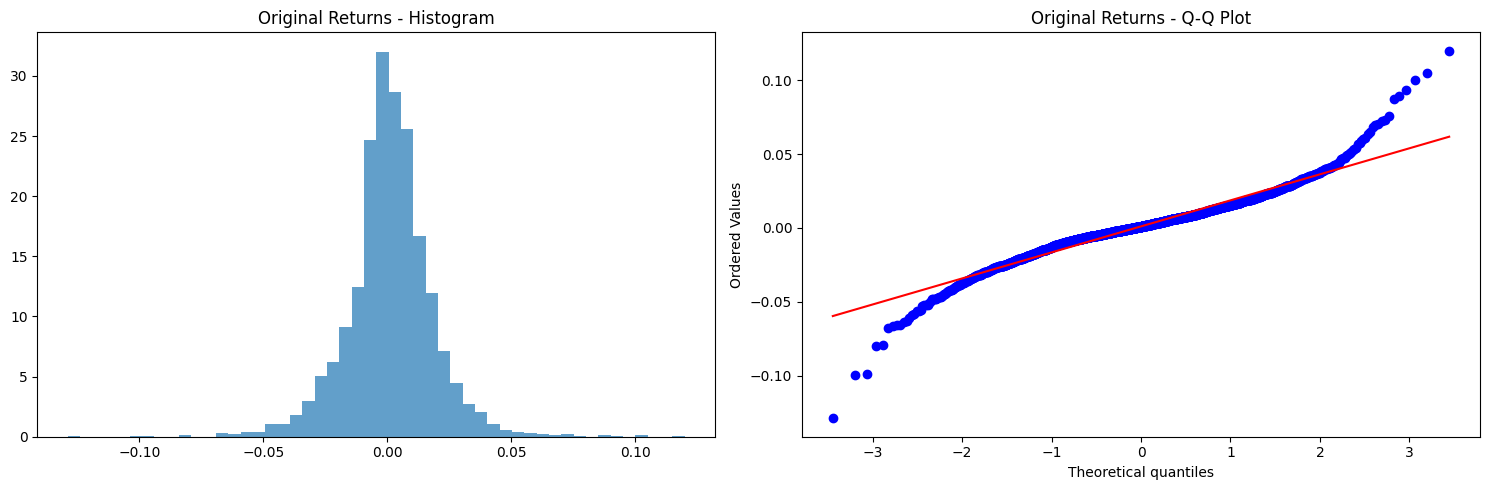

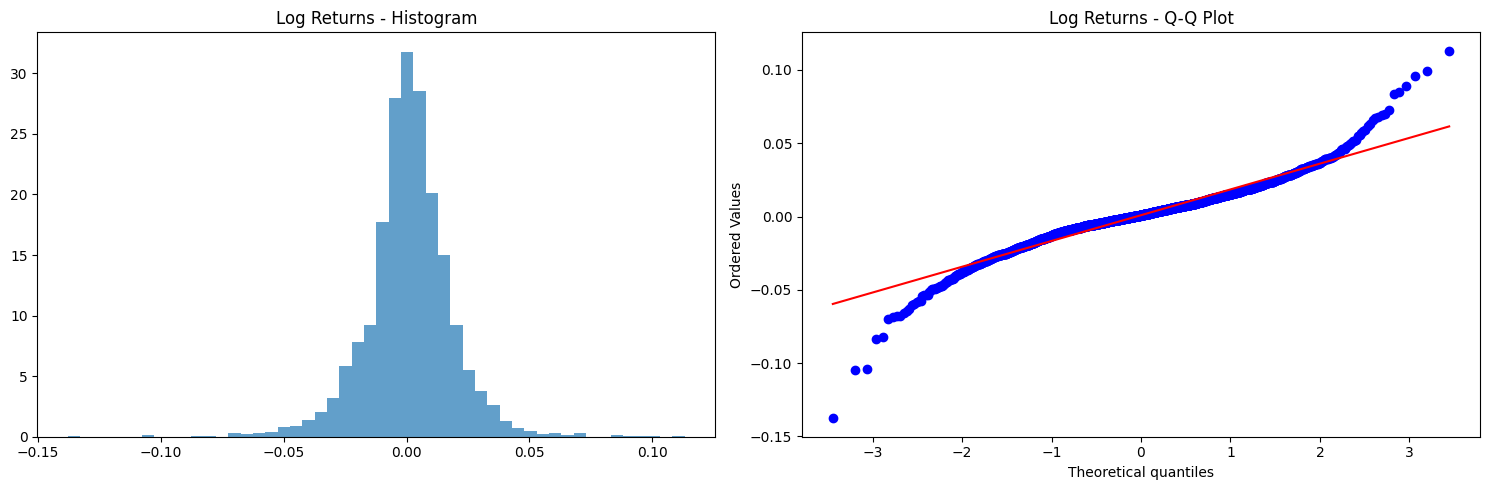

In [132]:
def plot_distribution(data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data, bins=50, density=True, alpha=0.7)
    ax1.set_title(f"{title} - Histogram")
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=ax2)
    ax2.set_title(f"{title} - Q-Q Plot")
    
    plt.tight_layout()
    plt.show()

plot_distribution(data['returns'].dropna(), "Original Returns")
plot_distribution(np.log1p(data['returns'].dropna()), "Log Returns")

Apply Shapiro-Wilk test

In [123]:
def is_normal(sample, test=stats.shapiro, p_level=0.05, **kwargs):
    """Apply a normality test to check if sample is normally distributed."""
    t_stat, p_value = test(sample, **kwargs)
    print("Test statistic: {}, p-value: {}".format(t_stat, p_value))
    print("Is the distribution Likely Normal? {}".format(p_value > p_level))
    return p_value > p_level

print("Sample A: Returns"); is_normal(data['returns'].dropna());
print("Sample B: Log Returns"); is_normal(data['log_returns'].dropna());

Sample A: Returns
Test statistic: 0.9428904850599394, p-value: 1.1905177524700952e-29
Is the distribution Likely Normal? False
Sample B: Log Returns
Test statistic: 0.9420176749542934, p-value: 7.65863593739985e-30
Is the distribution Likely Normal? False


Apply Kolmogorov-Smirnov test

In [125]:
def is_normal_ks(sample, test=stats.kstest, p_level=0.05, **kwargs):
    """
    sample: a sample distribution
    test: a function that tests for normality
    p_level: if the test returns a p-value > than p_level, assume normality
    
    return: True if distribution is normal, False otherwise
    """
    normal_args = (sample.mean(), sample.std())
    
    t_stat, p_value = test(sample, 'norm', normal_args, **kwargs)
    print("Test statistic: {}, p-value: {}".format(t_stat, p_value))
    print("Is the distribution Likely Normal? {}".format(p_value > p_level))
    return p_value > p_level

print("Sample A: Returns"); is_normal_ks(data['returns'].dropna());
print("Sample B: Log Returns"); is_normal_ks(data['log_returns'].dropna());

Sample A: Returns
Test statistic: 0.0747131285169996, p-value: 3.1865876510372755e-12
Is the distribution Likely Normal? False
Sample B: Log Returns
Test statistic: 0.07716637098523749, p-value: 5.194289798738604e-13
Is the distribution Likely Normal? False


In [ ]:
in[17]: from scipy.stats import boxcox, yeojohnson

# Box-Cox Transformation
data['boxcox_returns'], _ = boxcox(data['returns'].dropna() + 1)  # Box-Cox requires positive values
plot_distribution(data['boxcox_returns'], "Box-Cox Transformed Returns")

# Yeo-Johnson Transformation
data['yeojohnson_returns'], _ = yeojohnson(data['returns'].dropna())
plot_distribution(data['yeojohnson_returns'], "Yeo-Johnson Transformed Returns")

In [ ]:
print("Sample C: Box-Cox Transformed Returns"); is_normal(data['boxcox_returns']);
print("Sample D: Yeo-Johnson Transformed Returns"); is_normal(data['yeojohnson_returns']);